Notebook showcasing various examples of use of the algorithm in our ODfunctions library that does not appear in the manuscript "On proportional volume sampling for experimental design in general spaces". Please make sure the working directory is where the "ODfunctions.py" file is and all the required librairies are installed.

In [1]:
import os as os
os.chdir(".") #Working directory where the "ODfunctions.py" file is.
from ODfunctions import OptDesign, DOGS, LSA, ExM, Discrete_ExM, PHImono #Requires the packages: math, numpy, 
#cvxopt, matplotlib, scipy and dppy.
import numpy as np
import matplotlib.pyplot as plt
import time as time

# 1. Three circles

In this section, we consider the desing space $\Omega=B((0, 0), 1)\cup B((2, 0), 1)\cup B((1, \sqrt{3}), 1)$ as a toy example. We also consider that the regressing functions are the monomials with degree $\leq 3$ and the number of points in the designs are the same as the number of regressing functions. Note that the algorithm from De Castro et al. did not work in this case.

log D-optimality criterion for this random design chosen with a uniform distribution: -8.656103892949528


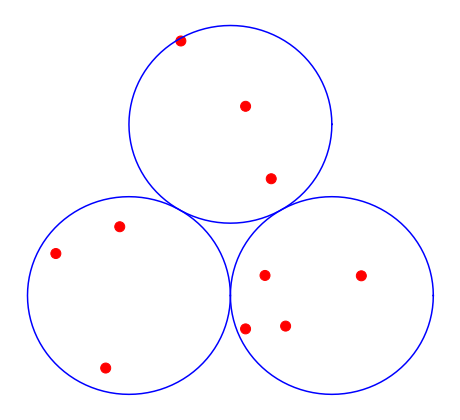

In [2]:
PHI = PHImono(2, 3)

def CircCara(P):
    Bool_Ar = np.logical_or(P[:, 0]**2+P[:, 1]**2 <= 1, (P[:, 0]-2)**2+P[:, 1]**2 <= 1)
    Bool_Ar = np.logical_or(Bool_Ar, (P[:, 0]-1)**2+(P[:, 1]-np.sqrt(3))**2 <= 1)
    return(Bool_Ar)

def CircRand(n): #Better sampler for the uniform distribution on the design space than a rejection method.
    A = np.random.rand(n, 2)
    a = np.random.randint(low=1, high=4, size=n)
    return np.vstack((np.sqrt(A[:, 0])*np.cos(2*np.pi*A[:, 1])+2*(a == 1)+1*(a == 2), np.sqrt(A[:, 0])*np.sin(2*np.pi*A[:, 1])+np.sqrt(3)*(a == 2))).T

def Circplot(ax):
    ang=2*np.pi*np.arange(0, 1.01, 0.01)
    ax.plot(np.cos(ang), np.sin(ang), 'b')
    ax.plot(2+np.cos(ang), np.sin(ang), 'b')
    ax.plot(1+np.cos(ang), np.sqrt(3)+np.sin(ang), 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [-1, -1], [3, 1+np.sqrt(3)], cara=CircCara, Urand=CircRand, plot_fun=Circplot)

P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit="D"))
OD.plot(P)

Here is an exemple of a design generated by each algorithm and a comparison of their performances.

log D-optimality criterion for one realization of DOGS after 200 iterations: -23.8469560374154
log D-optimality criterion for one realization of LSA after 2000 iterations: -23.727178857805704
log D-optimality criterion for one realization of ExM after 200 iterations: -19.294540876328412


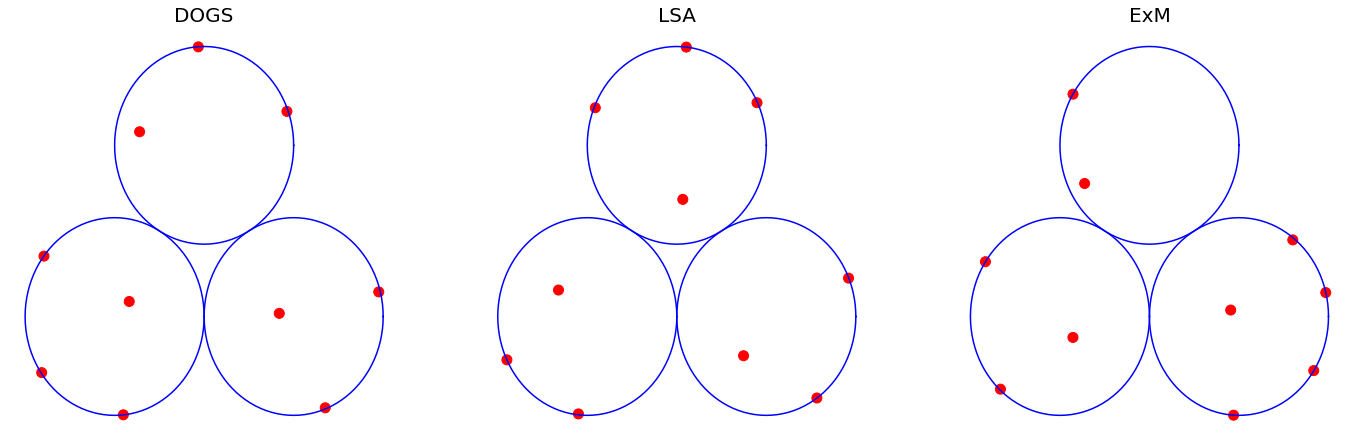

In [3]:
Algo_DOGS = DOGS(OD, 50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD, 0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig = OD.plot((P1, P2, P3), modify_plot=True)
fig.axes[0].set_title("DOGS", fontsize=20)
fig.axes[1].set_title("LSA", fontsize=20)
fig.axes[2].set_title("ExM", fontsize=20)
fig

Comparison of the performances of all algorithms.

In [4]:
algo_tuple = (DOGS(OD), LSA(OD, 0.01), ExM(OD))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_30grid = Discrete_ExM(OD, size=30)
print("Discrete ExM uses "+str(Algo_30grid.num_point())+" points.")
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_30grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Discrete ExM uses 526 points.
Progress: 100.00% 

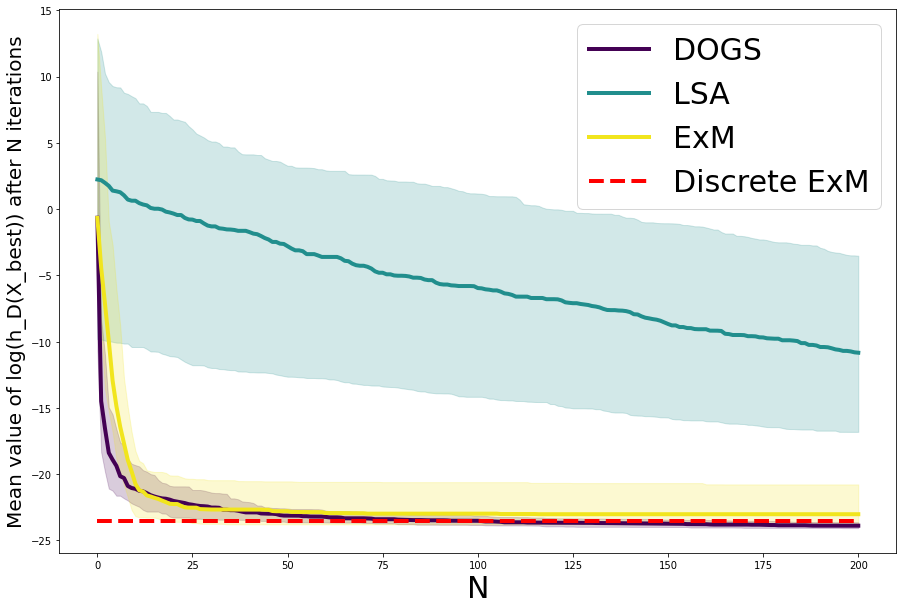

Average time for one realization of 200 iterations of DOGS: 2.328sec
Average time for one realization of 200 iterations of LSA: 0.079sec
Average time for one realization of 200 iterations of ExM: 2.100sec
Average time for one realization of Discrete ExM: 3.081sec


In [7]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(3):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.49))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
    
for k in range(3):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.49), alpha=.2)

plt.legend(labels=["DOGS", "LSA", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {List_time[1]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

# 2. The Moon

In this section, we consider the desing space $\Omega=B((-0.2, 0), 0.6)\backslash B((0.6, 0), 0.4)$. This is the same design space as in the paper of De Castro et al.
We also consider that the regressing functions are the monomials with degree $\leq 2$ and that the number of points in the designs is $50$, much higher than the number of regressing functions, in order to compare our result to the center plot of Figure 5 in the paper of De Castro et al.

log D-optimality criterion for this random design chosen with a uniform distribution: -2.7077626384761455


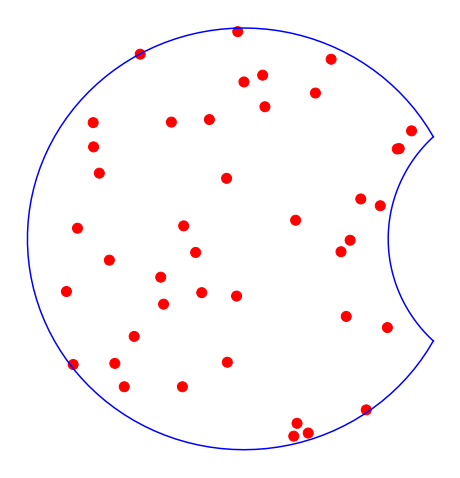

In [13]:
PHI = PHImono(2, 2)

def MoonCara(P):
    Bool_Ar = np.logical_and((P[:, 0]+0.2)**2+P[:, 1]**2 <= 0.36, (P[:, 0]-0.6)**2+P[:, 1]**2 >= 0.16)
    return(Bool_Ar)

def Moonplot(ax):
    ang1 = np.arccos((13/40+0.2)/0.6)
    ANG1 = np.linspace(ang1, 2*np.pi-ang1, 100)
    ang2 = np.arccos((13/40-0.6)/0.4)
    ANG2 = np.linspace(ang2, 2*np.pi-ang2, 100)
    ax.plot(-0.2+0.6*np.cos(ANG1), 0.6*np.sin(ANG1), 'b')
    ax.plot(0.6+0.4*np.cos(ANG2), 0.4*np.sin(ANG2), 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [-0.8, -0.6], [0.325, 0.6], nbpoint=42, cara=MoonCara, plot_fun=Moonplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit="D"))
OD.plot(P)

In their article, De castro et al. found the following optimal design:

log D-optimality criterion of the design: -5.999032656277131


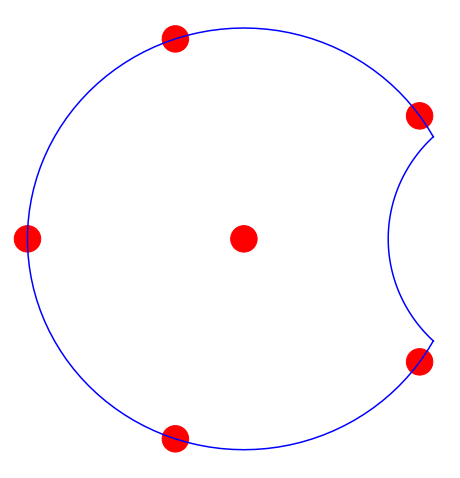

In [14]:
P_opt = np.array([[-0.39, -0.569], [-0.7999, 0], [-0.2, 0], [0.287, -0.35], [-0.39, 0.569], [0.287, 0.35]])
P_opt = np.vstack((P_opt, P_opt, P_opt, P_opt, P_opt, P_opt, P_opt))
print("log D-optimality criterion of the design:", end=" ")
print(OD.opt(P_opt))
OD.plot(P_opt)

Here is an exemple of a design generated by each algorithm and a comparison of their performances. We can already see in the examples that the designs closer to the results from De Castro et al. are the one generated by DOGS.

log D-optimality criterion for one realization of DOGS after 200 iterations: -5.78726115745939
log D-optimality criterion for one realization of LSA after 200 iterations: -4.021964857167015
log D-optimality criterion for one realization of ExM after 200 iterations: -5.508890429619045


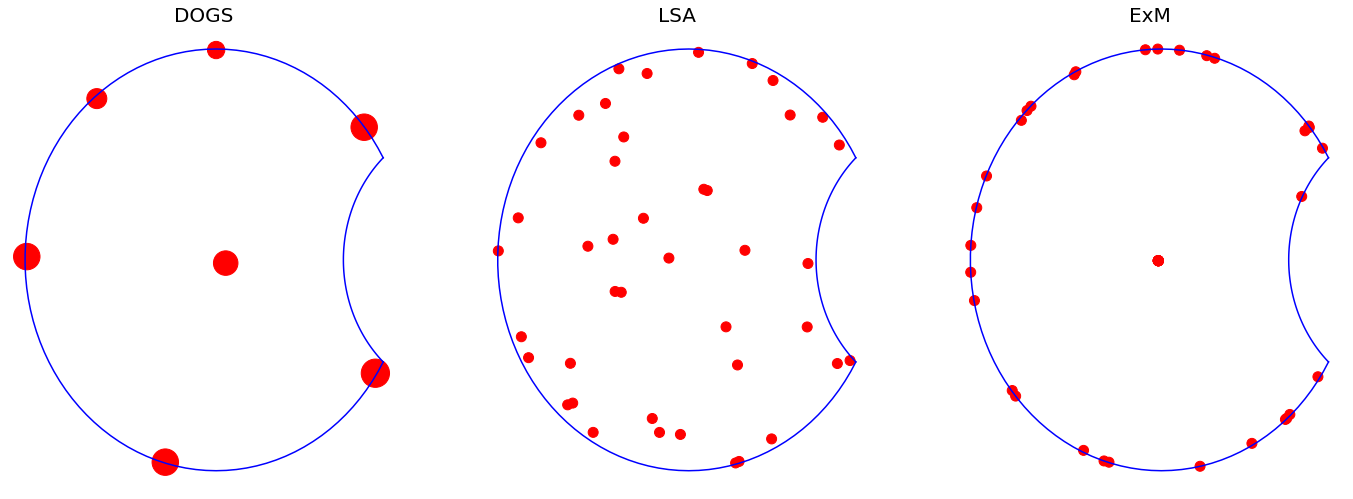

In [15]:
Algo_DOGS = DOGS(OD)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD, 0.05)
P2 = Algo_LSA.simulate(200)
print("log D-optimality criterion for one realization of LSA after 200 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig = OD.plot((P1, P2, P3), modify_plot=True)
fig.axes[0].set_title("DOGS", fontsize=20)
fig.axes[1].set_title("LSA", fontsize=20)
fig.axes[2].set_title("ExM", fontsize=20)
fig

Now, we compare the performances of all algorithms.

In [16]:
algo_tuple = (DOGS(OD), LSA(OD, 0.01), ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_25grid = Discrete_ExM(OD, size = 25)
print("Discrete ExM uses "+str(Algo_30grid.num_point())+" points.")
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_25grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Discrete ExM uses 526 points.
Progress: 100.00% 

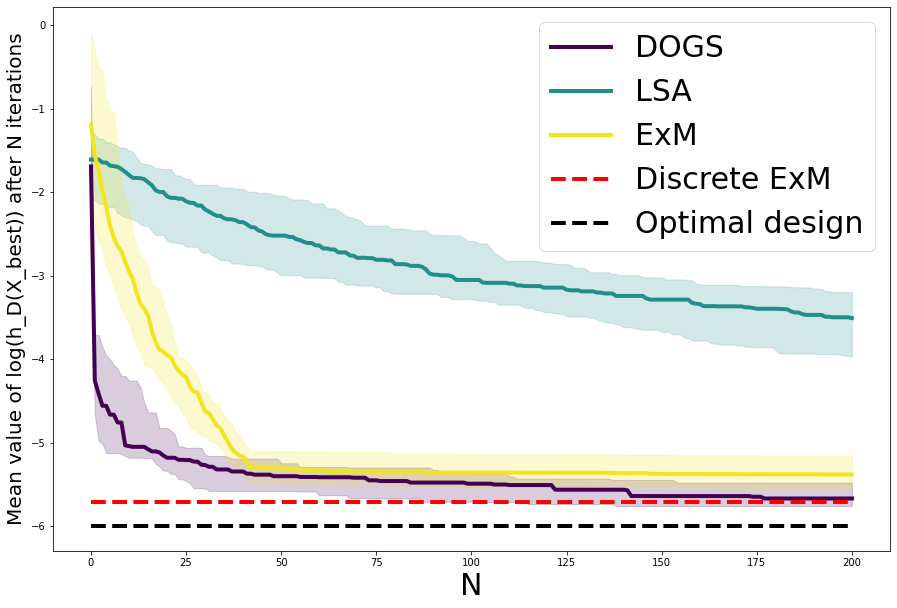

Average time for one realization of 200 iterations of DOGS: 0.879sec
Average time for one realization of 200 iterations of LSA: 0.063sec
Average time for one realization of 200 iterations of ExM: 1.800sec
Average time for one realization of Discrete ExM: 4.440sec


In [17]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(3):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.49))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
plt.plot([0, depth], [OD.opt(P_opt), OD.opt(P_opt)], '--', color="black" , linewidth=4)
    
for k in range(3):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.49), alpha=.2)

plt.legend(labels = ["DOGS", "LSA", "ExM", "Discrete ExM", "Optimal design"], fontsize=30)
plt.xlabel('N', fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {List_time[1]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/N_test:.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

# 3. Internal combustion engine performance

This example is taken from Example 12.2 in the book "Optimum Experimental Designs, with SAS" by Atkinson, Donev and Tobias.

log D-optimality criterion for this random design chosen with a uniform distribution: -14.91778117967239


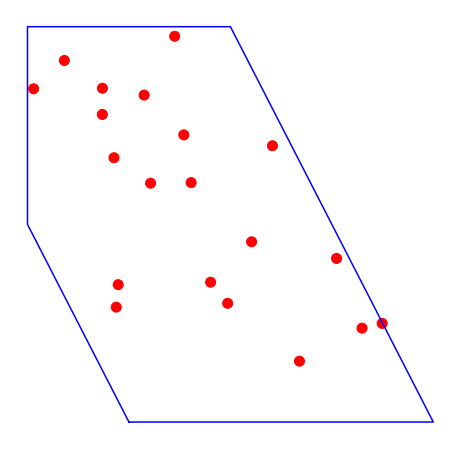

In [18]:
PHI = PHImono(2, 2)

def EngineCara(P):
    Bool_Ar = np.logical_and(P[:, 0] >= 0, P[:, 1] >= 0)
    Bool_Ar = np.logical_and(Bool_Ar, P[:, 1] <= 4)
    Bool_Ar = np.logical_and(Bool_Ar, P[:, 1]+2*P[:, 0] >= 2)
    Bool_Ar = np.logical_and(Bool_Ar, P[:, 1]+2*P[:, 0] <= 8)
    return(Bool_Ar)

def Engineplot(ax):
    ax.plot([1, 4, 2, 0, 0, 1], [0, 0, 4, 4, 2, 0], 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [0, 0], [4, 4], nbpoint=20, cara=EngineCara, plot_fun=Engineplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P))
OD.plot(P)

They found the following optimal design by running a discrete optimization algorithm on a discrete set of well-chosen candidate points.

Optimal log D-optimality criterion: -21.53708927176649


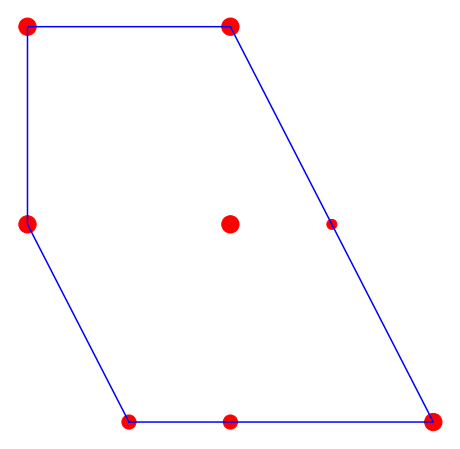

In [19]:
P_opt = np.array([[0, 4], [0, 4], [0, 4], [2, 4], [2, 4], [2, 4], [0, 2], [0, 2], [0, 2], [2, 2], [2, 2], [2, 2], [3, 2], [1, 0], [1, 0], [2, 0], [2, 0], [4, 0], [4, 0], [4, 0]])
print("Optimal log D-optimality criterion:", end=" ")
print(OD.opt(P_opt))
OD.plot(P_opt)

log D-optimality criterion for DOGS after 200 iterations: -20.98148036432944
log D-optimality criterion for LSA after 2000 iterations: -20.208402414716957
log D-optimality criterion for ExM after 200 iterations: -20.93409990698053


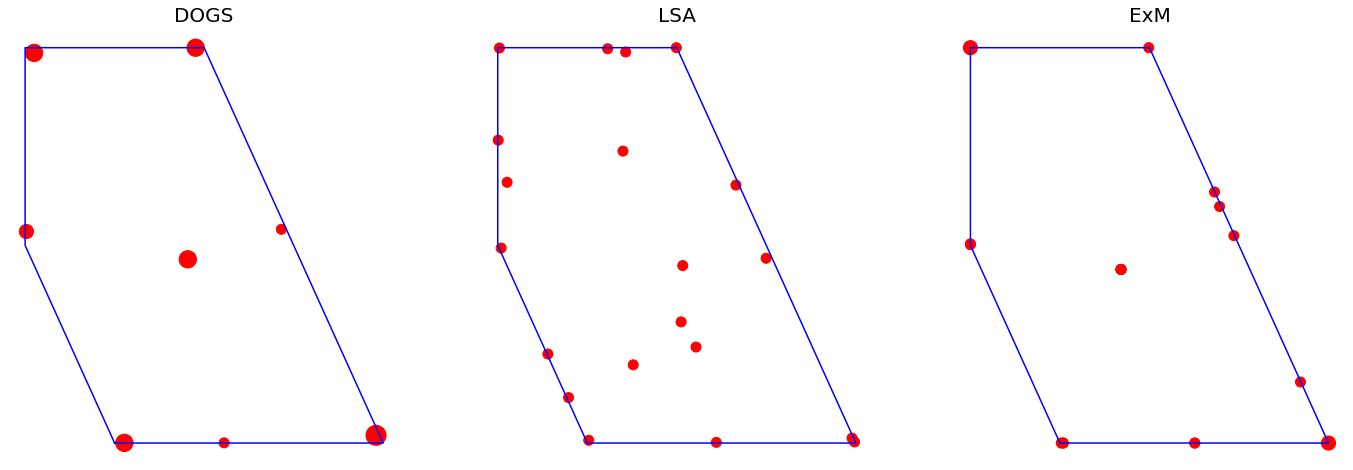

In [20]:
Algo_DOGS = DOGS(OD, 50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD, 0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for LSA after 2000 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig = OD.plot((P1, P2, P3), modify_plot=True)
fig.axes[0].set_title("DOGS", fontsize=20)
fig.axes[1].set_title("LSA", fontsize=20)
fig.axes[2].set_title("ExM", fontsize=20)
fig

Now, we compare the performances of all algorithms.

In [21]:
algo_tuple = (DOGS(OD, 50), LSA(OD, 0.01), ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done


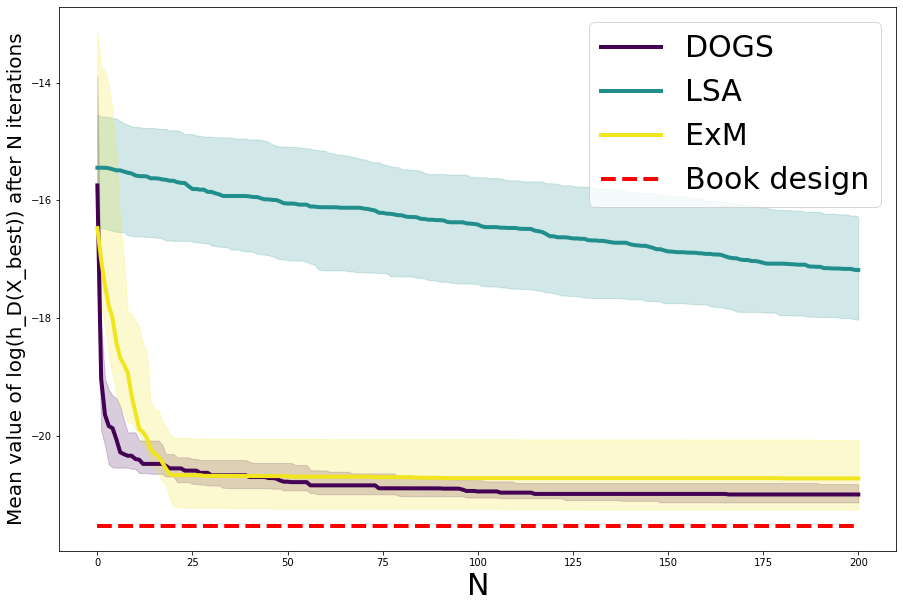

Average time for one realization of 200 iterations of DOGS: 2.575sec
Average time for one realization of 200 iterations of LSA: 0.071sec
Average time for one realization of 200 iterations of ExM: 0.896sec


In [22]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(3):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.49))
m = np.median(Discrete_Result)
plt.plot([0, depth], [OD.opt(P_opt), OD.opt(P_opt)], 'r--', linewidth=4)
    
for k in range(3):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.49), alpha=.2)

plt.legend(labels=["DOGS", "LSA", "ExM", "Book design"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {List_time[1]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/N_test:.3f}sec');

# 4. Mixture model with linear constraints

This example is taken from Example 16.2 in the book "Optimum Experimental Designs, with SAS" by Atkinson, Donev and Tobias. Note that we consider here the design space in the two variables $x_1$ and $x_2$ while in the book they consider the simplex plot corresponding the mixture design problem. We show here the plots of the design in both our design space and their simplex plot.

log D-optimality criterion for this random design chosen with a uniform distribution: 13.604922644094266


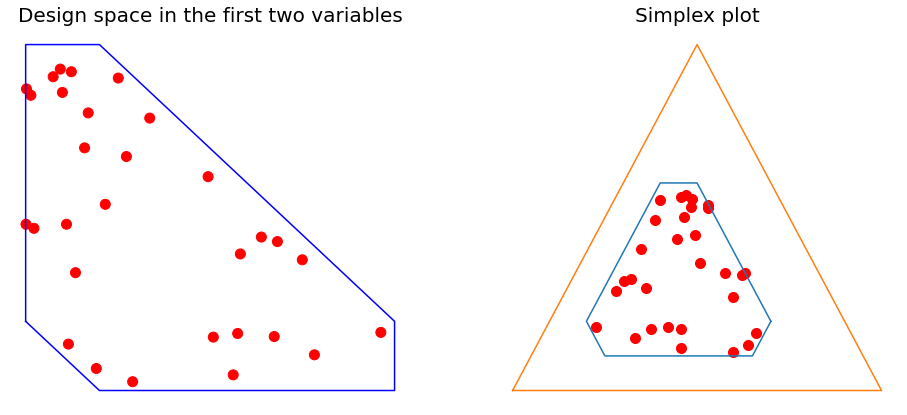

In [24]:
PHI = PHImono(2, 2)

def SimplexCara(P):
    Bool_Ar = np.logical_and(P[:, 0] >= 0.2, P[:, 0] <= 0.7)
    Bool_Ar = np.logical_and(Bool_Ar, P[:, 1] >= 0.1)
    Bool_Ar = np.logical_and(Bool_Ar, P[:, 1] <= 0.6)
    Bool_Ar = np.logical_and(Bool_Ar, np.round(1-(P[:, 1]+P[:, 0]), 10) >= 0.1)
    Bool_Ar = np.logical_and(Bool_Ar, np.round(1-(P[:, 1]+P[:, 0]), 10) <= 0.6)
    return(Bool_Ar)

def Simplexplot(ax):
    ax.plot([0.2, 0.2, 0.3, 0.7, 0.7, 0.3, 0.2], [0.2, 0.6, 0.6, 0.2, 0.1, 0.1, 0.2], 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [0, 0], [1, 1], nbpoint=30, cara=SimplexCara, plot_fun=Simplexplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P))
fig = OD.plot(P, modify_plot=True)

#Drawing the simplex plot
fig.axes[0].change_geometry(1, 2, 1)
fig.axes[0].set_title("Design space in the first two variables", fontsize=20)
fig.add_subplot(1, 2, 2)
fig.set_size_inches(16, 7)

A = np.array([0.2, 0.2, 0.3, 0.7, 0.7, 0.3, 0.2])
B = np.array([0.2, 0.6, 0.6, 0.2, 0.1, 0.1, 0.2])

A = 1-A-B/2
B *= np.sqrt(5)/2

Q = np.copy(P)
Q[:, 0] = 1-P[:, 0]-P[:, 1]/2
Q[:, 1] *= np.sqrt(5)/2

fig.axes[1].plot(A, B)
fig.axes[1].plot([0, 0.5, 1, 0], [0, np.sqrt(5)/2, 0, 0])
fig.axes[1].axis("off")
fig.axes[1].scatter(Q[:, 0], Q[:, 1], marker='o', c='r', s=100)
fig.axes[1].set_title("Simplex plot", fontsize=20)
fig

The authors also shares the optimal design they found using a discrete optimization method on a set of well-chosen candidate points. This is Figure 16.3 in Atkinson's book.

Optimal log D-optimality criterion: 9.753297144306606


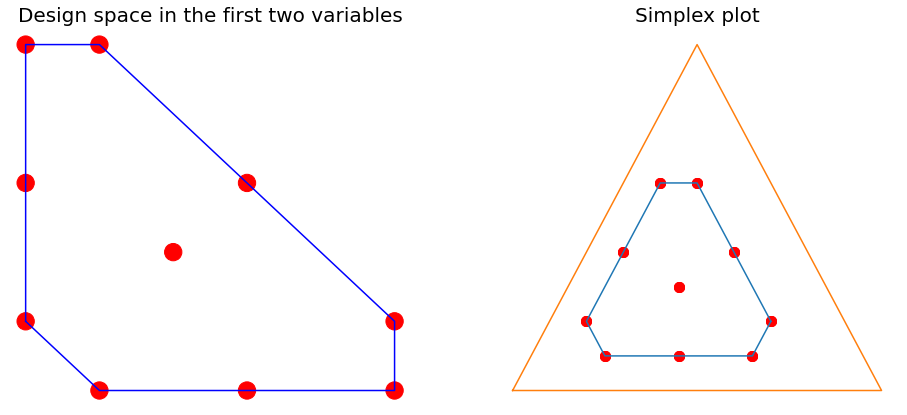

In [25]:
P_opt = np.array([[0.7, 0.1], [0.2, 0.6], [0.7, 0.2], [0.2, 0.2], [0.3, 0.6], [0.3, 0.1], [0.2, 0.4], [0.5, 0.1], [0.5, 0.4], [0.4, 0.3]])
P_opt = np.vstack((P_opt, P_opt, P_opt))
print("Optimal log D-optimality criterion:", end=" ")
print(OD.opt(P_opt))
fig = OD.plot(P_opt, modify_plot=True)

#Drawing the simplex plot
fig.axes[0].change_geometry(1, 2, 1)
fig.axes[0].set_title("Design space in the first two variables", fontsize=20)
fig.add_subplot(1, 2, 2)
fig.set_size_inches(16, 7)

Q = np.copy(P_opt)
Q[:, 0] = 1-P_opt[:, 0]-P_opt[:, 1]/2
Q[:, 1] *= np.sqrt(5)/2

fig.axes[1].plot(A, B)
fig.axes[1].plot([0, 0.5, 1, 0], [0, np.sqrt(5)/2, 0, 0])
fig.axes[1].axis("off")
fig.axes[1].scatter(Q[:, 0], Q[:, 1], marker='o', c='r', s=100)
fig.axes[1].set_title("Simplex plot", fontsize=20)
fig

Now, testing our algorithms in this case gives:

log D-optimality criterion for one realization of DOGS after 200 iterations: 10.235634956493696
log D-optimality criterion for one realization of LSA after 2000 iterations: 11.520355884221672
log D-optimality criterion for one realization of ExM after 200 iterations: 10.942617180300914


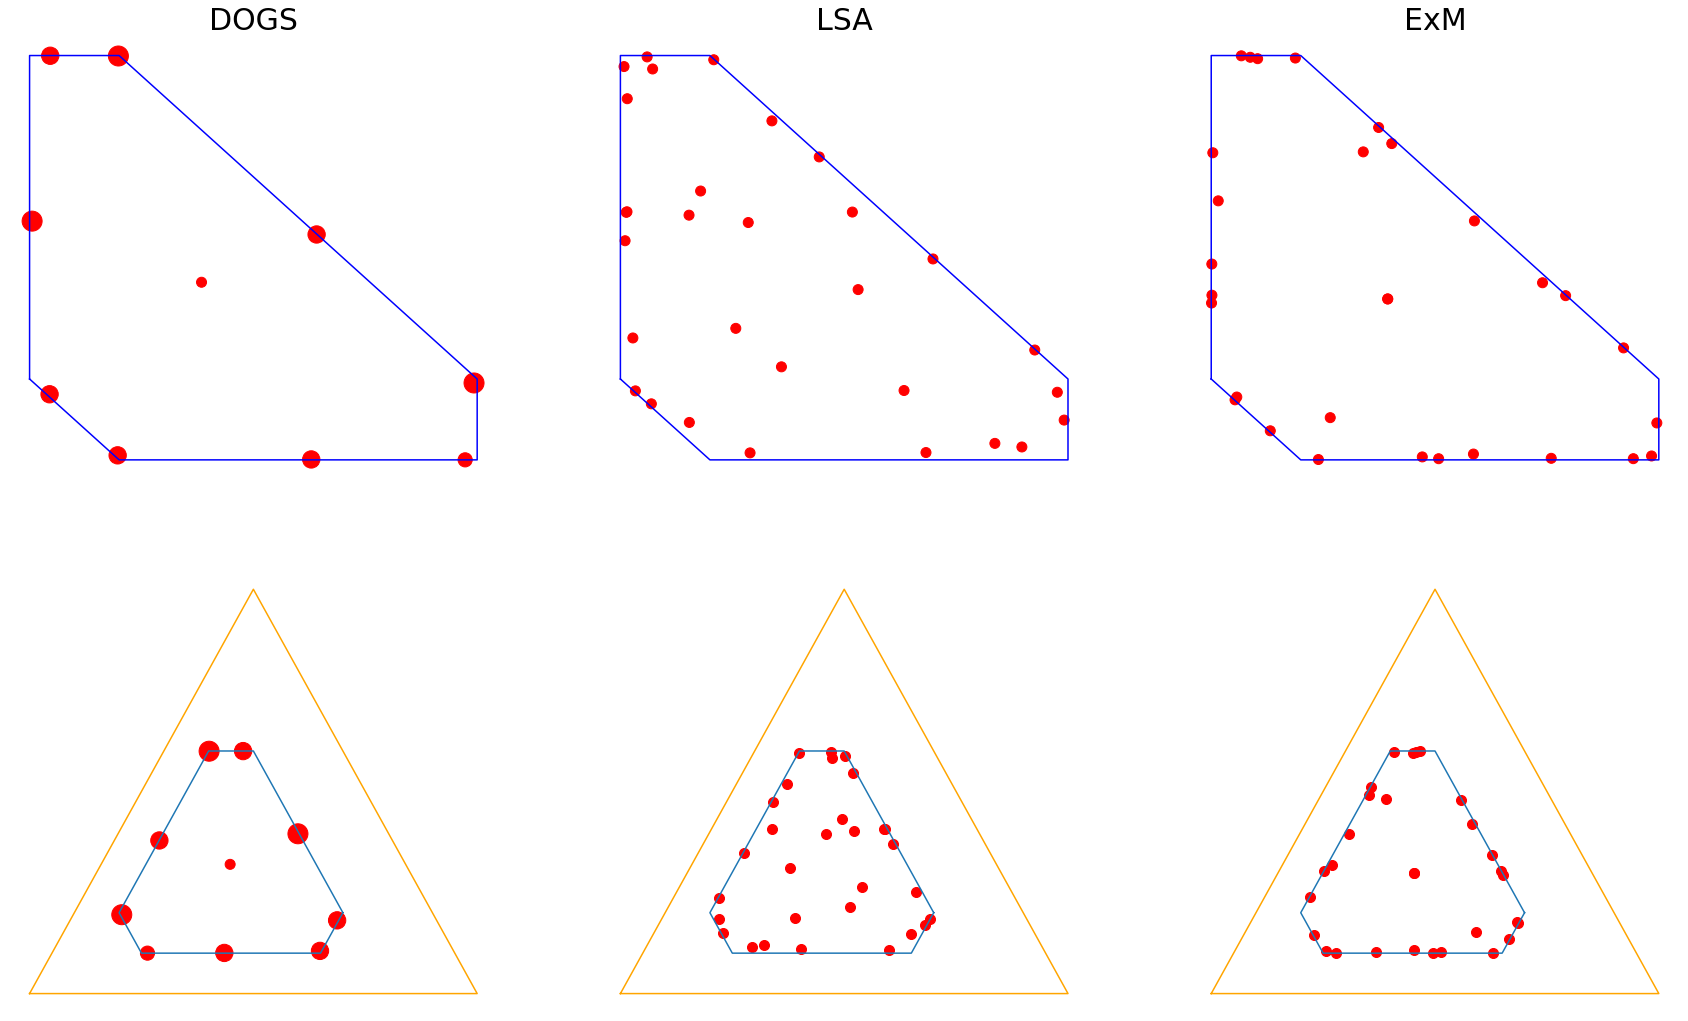

In [26]:
Algo_DOGS = DOGS(OD, 50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD, 0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig=OD.plot((P1, P2, P3), modify_plot=True)

#Drawing the simplex plot
fig.axes[0].set_title("DOGS", fontsize=30)
fig.axes[1].set_title("LSA", fontsize=30)
fig.axes[2].set_title("ExM", fontsize=30)

fig.axes[0].change_geometry(2, 3, 1)
fig.axes[1].change_geometry(2, 3, 2)
fig.axes[2].change_geometry(2, 3, 3)
fig.add_subplot(2, 3, 4)
fig.add_subplot(2, 3, 5)
fig.add_subplot(2, 3, 6)
fig.set_size_inches(30, 18)

Q1 = np.copy(P1)
Q1[:, 0] = 1-P1[:, 0]-P1[:, 1]/2
Q1[:, 1] *= np.sqrt(5)/2

Q2 = np.copy(P2)
Q2[:, 0] = 1-P2[:, 0]-P2[:, 1]/2
Q2[:, 1] *= np.sqrt(5)/2

Q3 = np.copy(P3)
Q3[:, 0] = 1-P3[:, 0]-P3[:, 1]/2
Q3[:, 1] *= np.sqrt(5)/2

fig.axes[3].plot(A, B)
fig.axes[3].plot([0, 0.5, 1, 0], [0, np.sqrt(5)/2, 0, 0], 'orange')
fig.axes[3].axis("off")
Pt, Nb = np.unique([tuple(row) for row in Q1], axis=0, return_counts=True)
fig.axes[3].scatter(Pt[:, 0], Pt[:, 1], marker='o', c='r', s=100*Nb)

fig.axes[4].plot(A, B)
fig.axes[4].plot([0, 0.5, 1, 0], [0, np.sqrt(5)/2, 0, 0], 'orange')
fig.axes[4].axis("off")
fig.axes[4].scatter(Q2[:, 0], Q2[:, 1], marker='o', c='r', s=100)

fig.axes[5].plot(A, B)
fig.axes[5].plot([0, 0.5, 1, 0], [0, np.sqrt(5)/2, 0, 0], 'orange')
fig.axes[5].axis("off")
fig.axes[5].scatter(Q3[:, 0], Q3[:, 1], marker='o', c='r', s=100)
fig

In [27]:
algo_tuple = (DOGS(OD, 50), LSA(OD, 0.01), ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done


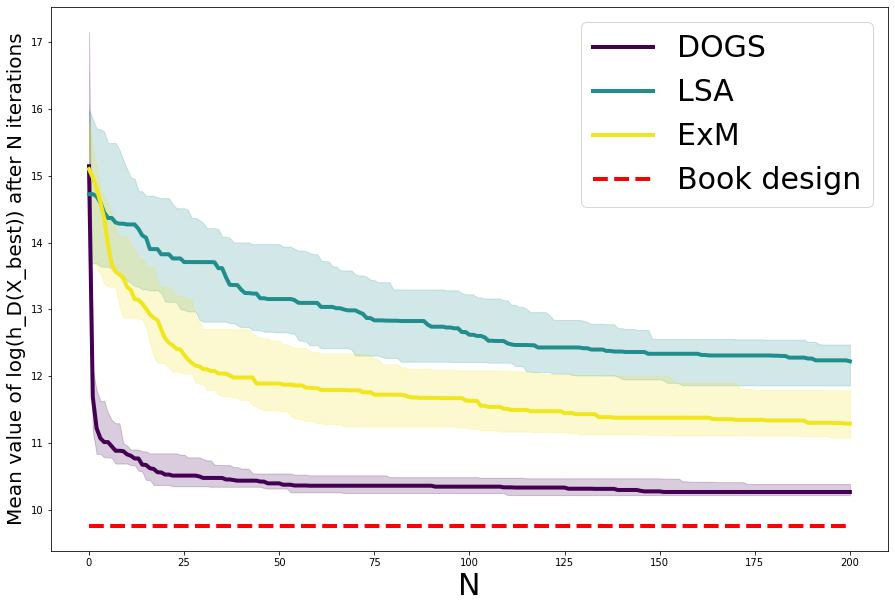

Average time for one realization of 200 iterations of DOGS: 2.914sec
Average time for one realization of 200 iterations of LSA: 0.089sec
Average time for one realization of 200 iterations of ExM: 2.575sec


In [28]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(3):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.49))
m = np.median(Discrete_Result)
plt.plot([0, depth], [OD.opt(P_opt), OD.opt(P_opt)], 'r--', linewidth=4)
    
for k in range(3):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.49), alpha=.2)

plt.legend(labels=["DOGS", "LSA", "ExM", "Book design"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {List_time[1]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/N_test:.3f}sec');

## 5. Paper examples in a Bayesian setting

In this section, we are showcasing the performances of each algorithm in the search for a Bayesian optimal design in some of the examples of our manuscript.

### a. Three-component mixture design with quadratic constraints

In [2]:
def SimplexCara(P): #Characteristic function of the design space.
    Bool_Ar = np.logical_and(-1.174*P[:, 0]**2+1.057*P[:, 0]+P[:, 1] <= 0.5019,\
                             -4.062*P[:, 0]**2+2.962*P[:, 0]+P[:, 1] >= 0.6075)
    return(Bool_Ar)

def Simplexplot(ax): #Plot function of the design space.
    a = 2.888
    b = -1.905
    c = 0.1056
    Delta = b**2-4*a*c
    x0 = (-b-np.sqrt(Delta))/(2*a)
    x1 = (-b+np.sqrt(Delta))/(2*a)
    t = np.linspace(x0, x1, 50)
    ax.plot(t, 1.174*t**2-1.057*t+0.5019, 'b')
    ax.plot(t, 4.062*t**2-2.962*t+0.6075, 'b')
    ax.axis("off")
    return ax

#The design space is a cube and we consider a Bayesian setting with inverse prior 
#covariance of 0.001xI_10
OD_3mix_deg4 = OptDesign(PHImono(2, 4), [0, 0], [1, 1], nbpoint=30, 
                         cara=SimplexCara, plot_fun=Simplexplot, inv_prior=0.001)

In [3]:
algo_tuple = (DOGS(OD_3mix_deg4, 50), LSA(OD_3mix_deg4, 0.01), ExM(OD_3mix_deg4))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_100grid = Discrete_ExM(OD_3mix_deg4, size=100)
N_discrete_test = 10

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_100grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD_3mix_deg4.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

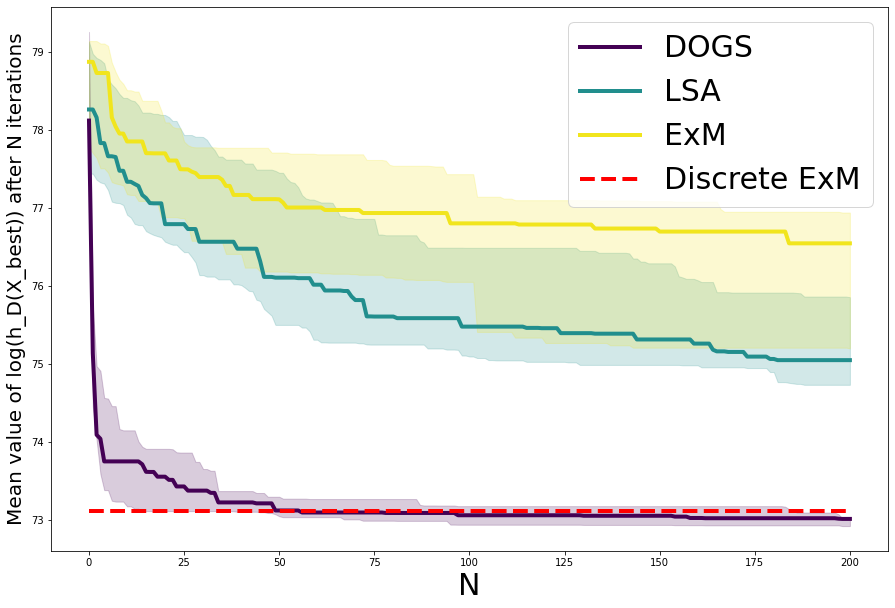

Average time for one realization of 200 iterations of DOGS: 13.824sec
Average time for one realization of 200 iterations of LSA: 0.200sec
Average time for one realization of 200 iterations of ExM: 5.188sec
Average time for one realization of Discrete ExM: 29.436sec


In [4]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(3):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.49))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
    
for k in range(3):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.49), alpha=.2)

plt.legend(labels=["DOGS", "LSA", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1])/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

### b. Multifactor B-Spline Mixed Models

In [7]:
from scipy.interpolate import BSpline

#Defintion of the B-Spline functions
knots = [0, 0, 0, 0, 0.25, 0.5, 0.75, 1, 1, 1, 1]

f1 = BSpline(knots, [1, 0, 0, 0, 0, 0, 0], 3)
f2 = BSpline(knots, [0, 1, 0, 0, 0, 0, 0], 3)
f3 = BSpline(knots, [0, 0, 1, 0, 0, 0, 0], 3)
f4 = BSpline(knots, [0, 0, 0, 1, 0, 0, 0], 3)
f5 = BSpline(knots, [0, 0, 0, 0, 1, 0, 0], 3)
f6 = BSpline(knots, [0, 0, 0, 0, 0, 1, 0], 3)
f7 = BSpline(knots, [0, 0, 0, 0, 0, 0, 1], 3)

#Regression functions used in the paper of Grove et al.
def PHI(P):
    return np.vstack((0*P[:, 0]+1, f2(P[:, 0]), f3(P[:, 0]), f4(P[:, 0]), f5(P[:, 0]), f6(P[:, 0]), f7(P[:, 0]), \
        P[:, 1], P[:, 1]**2, P[:, 1]**3, P[:, 2], P[:, 2]**2, P[:, 2]**3, \
            P[:, 1]*f2(P[:, 0]), P[:, 1]*f3(P[:, 0]), P[:, 1]*f4(P[:, 0]), P[:, 1]*f5(P[:, 0]), P[:, 1]*f6(P[:, 0]), P[:, 1]*f7(P[:, 0]), \
                P[:, 2]*f2(P[:, 0]), P[:, 2]*f3(P[:, 0]), P[:, 2]*f4(P[:, 0]), P[:, 2]*f5(P[:, 0]), P[:, 2]*f6(P[:, 0]), P[:, 2]*f7(P[:, 0]), \
                    P[:, 1]*P[:, 2], P[:, 0]*P[:, 1]**2, P[:, 0]*P[:, 2]**2, P[:, 1]*P[:, 2]**2, P[:, 2]*P[:, 1]**2, P[:, 0]*P[:, 1]*P[:, 2])).T

#The design space is a cube and we consider a Bayesian setting with inverse prior covariance of 0.1xI_30
OD_BSpline_Cube = OptDesign(PHI, [0, 0, 0], [1, 1, 1], nbpoint=55, inv_prior=0.1)

In [8]:
#Generating both sets of candidate points

from scipy.optimize import minimize, Bounds

#Defining the maximum of the B-splines.
x1 = minimize(lambda x:-f2(x), np.array([0.2]), bounds=Bounds(tuple([0]), tuple([1]))).x
x2 = minimize(lambda x:-f3(x), np.array([0.5]), bounds=Bounds(tuple([0]), tuple([1]))).x
x3 = minimize(lambda x:-f4(x), np.array([0.5]), bounds=Bounds(tuple([0]), tuple([1]))).x
x4 = minimize(lambda x:-f5(x), np.array([0.5]), bounds=Bounds(tuple([0]), tuple([1]))).x
x5 = minimize(lambda x:-f6(x), np.array([0.8]), bounds=Bounds(tuple([0]), tuple([1]))).x

from ODfunctions import RegP #Function generating regular grids

#First set of candidate points for DOGS
P = RegP([0, 0], [1, 1], 2)
P1 = np.hstack((np.array([[0 for _ in range(4)]]).T, P))
P2 = np.hstack((np.array([x1 for _ in range(4)]), P))
P3 = np.hstack((np.array([x2 for _ in range(4)]), P))
P4 = np.hstack((np.array([x3 for _ in range(4)]), P))
P5 = np.hstack((np.array([x4 for _ in range(4)]), P))
P6 = np.hstack((np.array([x5 for _ in range(4)]), P))
P7 = np.hstack((np.array([[1 for _ in range(4)]]).T, P))
CP = np.vstack((P1, P2, P3, P4, P5, P6, P7))

#Second set of candidate points for Discrete ExM
P = RegP([0, 0], [1, 1], 10)
P1 = np.hstack((np.array([[0 for _ in range(100)]]).T, P))
P2 = np.hstack((np.array([x1 for _ in range(100)]), P))
P3 = np.hstack((np.array([x2 for _ in range(100)]), P))
P4 = np.hstack((np.array([x3 for _ in range(100)]), P))
P5 = np.hstack((np.array([x4 for _ in range(100)]), P))
P6 = np.hstack((np.array([x5 for _ in range(100)]), P))
P7 = np.hstack((np.array([[1 for _ in range(100)]]).T, P))
CP2 = np.vstack((P1, P2, P3, P4, P5, P6, P7))

In [9]:
algo_tuple = (DOGS(OD_BSpline_Cube, 50), DOGS(OD_BSpline_Cube, 22, CP=CP), LSA(OD_BSpline_Cube, 0.01), ExM(OD_BSpline_Cube))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_nogrid_withCP = Discrete_ExM(OD_BSpline_Cube, CP=CP2)  
N_discrete_test = 10

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_nogrid_withCP.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD_BSpline_Cube.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

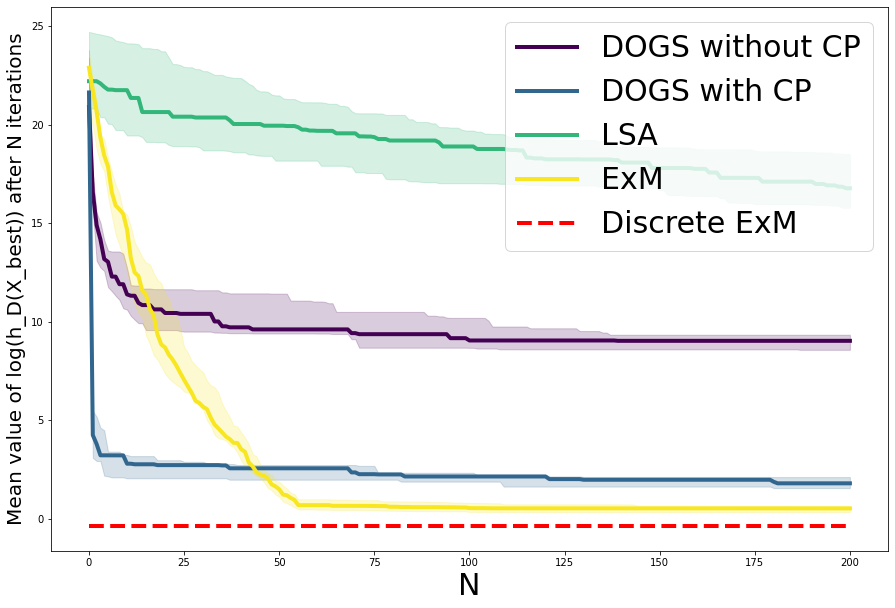

Average time for one realization of 200 iterations of DOGS: 42.692sec
Average time for one realization of 200 iterations of LSA: 42.087sec
Average time for one realization of 200 iterations of ExM: 0.639sec
Average time for one realization of Discrete ExM: 157.844sec


In [10]:
#Plotting the results

plt.figure(figsize = (15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(4):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.33))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
    
for k in range(4):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.33), alpha=.2)

plt.legend(labels=["DOGS without CP", "DOGS with CP", "LSA", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1])/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

### c. Nepheline crystallization in high-level nuclear waste glass

In [2]:
lp = [0.215, 0.14, 0, 0.02, 0, 0.07, 0.225]
up = [0.32, 0.24, 0.05, 0.05, 0.06, 0.16, 0.335]

PHI = PHImono(7, 2)

def NCCara(P):
    Bool_Ar = np.logical_and(np.sum(P, axis=1) <= 0.97, np.sum(P, axis = 1) >= 0.88)
    Lin_cstr = 11.670065*P[:, 0]-7.446645*P[:, 1]-7.605447*P[:, 2]-0.110824*P[:, 3]-32.673443*P[:, 4]-9.308093*P[:, 5]+8.880917*P[:, 6]+3.768904*(1-np.sum(P, axis=1))
    Bool_Ar = np.logical_and(Bool_Ar, Lin_cstr <= np.log(10))
    Bool_Ar = np.logical_and(Bool_Ar, Lin_cstr >= np.log(4))
    D = P[:, 5]+0.878*P[:, 4]+0.3*P[:, 2]+P[:, 0]+P[:, 6]+1.733*P[:, 1]
    g_SiB = (P[:, 6]+1.733*P[:, 1])/D
    g_AlFe = P[:, 0]/D
    g_Alk = (P[:, 5]+0.878*P[:, 4]+0.3*P[:, 2])/D
    LP = -28.874*g_Alk-55.441*g_AlFe-10.173*g_SiB+605.927*g_Alk*g_AlFe
    Non_Lin_cstr = np.exp(LP)/(1+np.exp(LP))
    Bool_Ar = np.logical_and(Bool_Ar, Non_Lin_cstr <= 0.65)
    Bool_Ar = np.logical_and(Bool_Ar, Non_Lin_cstr >= 0.20)
    for i in range(7):
        Bool_Ar = np.logical_and(Bool_Ar, P[:, i] <= up[i])
        Bool_Ar = np.logical_and(Bool_Ar, P[:, i] >= lp[i])
    return(Bool_Ar)

OD_Nepheline = OptDesign(PHI, lp, up, cara=NCCara, inv_prior=0.0001*np.eye(36))
#Inverse covariance matrix of 0.0001*I_{36}

In [3]:
#Generating candidate points

lp = [0.215, 0.14, 0, 0.02, 0, 0.07, 0.225]
up = [0.32, 0.24, 0.05, 0.05, 0.06, 0.16, 0.335]

def f_fun(P):
    return np.sum(P, axis = 1)
# 0.88 <= f_fun <= 0.97

def g_fun(P):
    return 11.670065*P[:, 0]-7.446645*P[:, 1]-7.605447*P[:, 2]-0.110824*P[:, 3]-32.673443*P[:, 4]-9.308093*P[:, 5]+8.880917*P[:, 6]+3.768904*(1-np.sum(P, axis=1))
# np.log(4) <= g_fun <= np.log(10)

def h_fun(P):
    D = P[:, 5]+0.878*P[:, 4]+0.3*P[:, 2]+P[:, 0]+P[:, 6]+1.733*P[:, 1]
    g_SiB = (P[:, 6]+1.733*P[:, 1])/D
    g_AlFe = P[:, 0]/D
    g_Alk = (P[:, 5]+0.878*P[:, 4]+0.3*P[:, 2])/D
    LP = -28.874*g_Alk-55.441*g_AlFe-10.173*g_SiB+605.927*g_Alk*g_AlFe
    return np.exp(LP)/(1+np.exp(LP))
# 0.20 <= h_fun <= 0.65

L = [-1, 1, -1, -1, 1, 1, 0]
def testedge(L):
    n = 1000
    P = np.array([[0., 0, 0, 0, 0, 0, 0]])
    for i in range(7):
        if L[i] == -1:
            P[:, i] = lp[i]
        elif L[i] == 1:
            P[:, i] = up[i]
        else:
            P = P*np.ones((n, 1))
            X = np.linspace(lp[i], up[i], n)
            P[:, i] = X
            
    Yf = f_fun(P)
    Yg = g_fun(P)
    Yh = h_fun(P)
 
    B1 = np.logical_and(Yf <= 0.97 , Yf >= 0.88)
    B2 = np.logical_and(Yg <= np.log(10) , Yg >= np.log(4))
    B3 = np.logical_and(Yh <= 0.65 , Yh >= 0.20)
    
    Bcomb = np.logical_and(B1, B2)
    Bcomb = np.logical_and(Bcomb, B3)
    return X[Bcomb]

def getpoint(L, res):
    P=np.array([[0., 0, 0, 0, 0, 0, 0]])
    for i in range(7):
        if L[i] == -1:
            P[:, i] = lp[i]
        elif L[i] == 1:
            P[:, i] = up[i]
        else:
            P = P*np.ones((2, 1))
            P[:, i] = np.array([np.min(res), np.max(res)])
    return P

from ODfunctions import RegP #Function generating regular grids
Lall = RegP([-1, -1, -1, -1, -1, -1], [1, 1, 1, 1, 1, 1], 2)
Lall = np.hstack((Lall, np.array([[0 for _ in range(64)]]).T))
CP = np.array([])
CP.shape = (0, 7)
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP = np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))

Lall = Lall[:, [0, 1, 2, 3, 4, 6, 5]]
for row in Lall:
    res=testedge(row)
    if len(res)>0:
        CP=np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))
        
Lall = Lall[:, [0, 1, 2, 3, 5, 4, 6]]
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP = np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))
        
Lall = Lall[:, [0, 1, 2, 4, 3, 5, 6]]
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP=np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))
        
Lall = Lall[:, [0, 1, 3, 2, 4, 5, 6]]
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP = np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))
        
Lall = Lall[:, [0, 2, 1, 3, 4, 5, 6]]
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP = np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))
        
Lall = Lall[:, [1, 0, 2, 3, 4, 5, 6]]
for row in Lall:
    res = testedge(row)
    if len(res)>0:
        CP = np.vstack((CP, getpoint(row, res)))
        print(row, np.min(res), np.max(res))

[-1. -1.  1.  1.  1. -1.  0.] 0.29503003003003003 0.2954704704704705
[ 1. -1.  1.  1.  1. -1.  0.] 0.2695945945945946 0.27994494494494493
[-1. -1. -1. -1.  1.  0.  1.] 0.11000000000000001 0.12090090090090092
[-1. -1. -1.  1.  1.  0.  1.] 0.09837837837837839 0.12090090090090092
[-1. -1.  1. -1.  1.  0.  1.] 0.08333333333333334 0.10585585585585586
[-1. -1.  1.  1.  1.  0.  1.] 0.08333333333333334 0.09738738738738739
[-1.  0.  1. -1. -1.  1. -1.] 0.21007007007007006 0.22218218218218216
[-1.  0.  1.  1. -1.  1. -1.] 0.20536536536536537 0.21187187187187187
[ 1.  0.  1. -1.  1. -1. -1.] 0.16572572572572575 0.19705705705705706
[ 1.  0.  1.  1.  1. -1. -1.] 0.16572572572572575 0.19495495495495496
[ 0.  1. -1.  1. -1.  1. -1.] 0.28426426426426427 0.294984984984985
[ 0.  1.  1. -1. -1.  1. -1.] 0.24022522522522521 0.27490990990990993


In [4]:
algo_tuple = (DOGS(OD_Nepheline, 100), DOGS(OD_Nepheline, 76, CP=CP), LSA(OD_Nepheline, 0.001), ExM(OD_Nepheline))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_4grid = Discrete_ExM(OD_Nepheline, size = 4, CP = CP)
N_discrete_test = 10

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_4grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD_Nepheline.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end = " ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

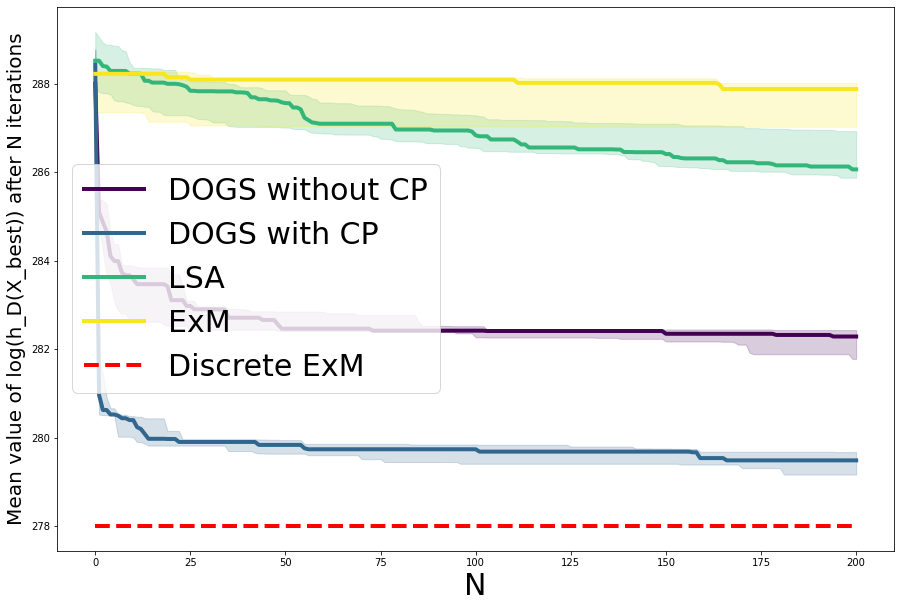

Average time for one realization of 200 iterations of DOGS: 39.745sec
Average time for one realization of 200 iterations of LSA: 40.113sec
Average time for one realization of 200 iterations of ExM: 1.523sec
Average time for one realization of Discrete ExM: 74.906sec


In [5]:
#Plotting the results

plt.figure(figsize = (15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(4):
    plt.plot(List_median[k], linewidth = 4, color = viridis(k*0.33))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth = 4)
    
for k in range(4):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color = viridis(k*0.33), alpha = .2)

plt.legend(labels = ["DOGS without CP", "DOGS with CP", "LSA", "ExM", "Discrete ExM"], fontsize = 30)
plt.xlabel('N', fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize = 20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {List_time[1]/N_test:.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[2]/N_test:.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');